In [2]:
import math as m
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt
%matplotlib inline



In [3]:
def S(basis) :
    N = basis.shape[0]
    Overlap_matrix = np.zeros((N,N))
    for p in range(N) :
        for q in range(p,N) :
            Overlap_matrix[p,q] = (np.pi/(basis[p] + basis[q]))**(3/2)
            Overlap_matrix[q,p] = Overlap_matrix[p,q]
    return Overlap_matrix

def T(basis) :
    N = basis.shape[0]
    Kintetic_matrix = np.zeros((N,N))
    for p in range(N) :
        for q in range(p,N) :
            Kintetic_matrix[p,q] = 3*basis[p]*basis[q]*np.pi**(3/2)/(basis[p] + basis[q])**(5/2)
            Kintetic_matrix[q,p] = Kintetic_matrix[p,q]
    return Kintetic_matrix

def A(basis) :
    N = basis.shape[0]
    Coulomb_matrix = np.zeros((N,N))
    for p in range(N) :
        for q in range(p,N) :
            Coulomb_matrix[p,q] = -8*np.pi/(basis[p] + basis[q])
            Coulomb_matrix[q,p] = Coulomb_matrix[p,q]
    return Coulomb_matrix


In [4]:
def Q(basis) : 
    N = basis.shape[0]
    Electron_matrix = np.zeros((N,N,N,N))
    for p in range(N) :
        for q in range(p+1) :
            for r in range(p+1) :
                if p != q :
                    for s in range(r+1) :
                        Electron_matrix[p,r,q,s] = 2*np.pi**(5/2)/(basis[p] + basis[q])/(basis[r] + basis[s])/(basis[p] + basis[q] + basis[r] + basis[s])**(1/2)
                        Electron_matrix[p,s,q,r] = Electron_matrix[p,r,q,s]
                        Electron_matrix[q,r,p,s] = Electron_matrix[p,r,q,s]
                        Electron_matrix[q,s,p,r] = Electron_matrix[p,r,q,s]
                        Electron_matrix[r,p,s,q] = Electron_matrix[p,r,q,s]
                        Electron_matrix[r,q,s,p] = Electron_matrix[p,r,q,s]
                        Electron_matrix[s,p,r,q] = Electron_matrix[p,r,q,s]
                        Electron_matrix[s,q,r,p] = Electron_matrix[p,r,q,s]
                else :
                    for s in range(q+1) :
                        Electron_matrix[p,r,q,s] = 2*np.pi**(5/2)/(basis[p] + basis[q])/(basis[r] + basis[s])/(basis[p] + basis[q] + basis[r] + basis[s])**(1/2)
                        Electron_matrix[p,s,q,r] = Electron_matrix[p,r,q,s]
                        Electron_matrix[q,r,p,s] = Electron_matrix[p,r,q,s]
                        Electron_matrix[q,s,p,r] = Electron_matrix[p,r,q,s]
                        Electron_matrix[r,p,s,q] = Electron_matrix[p,r,q,s]
                        Electron_matrix[r,q,s,p] = Electron_matrix[p,r,q,s]
                        Electron_matrix[s,p,r,q] = Electron_matrix[p,r,q,s]
                        Electron_matrix[s,q,r,p] = Electron_matrix[p,r,q,s]
    return Electron_matrix

In [5]:
def normalize(C,S) :
    I = 0
    N = np.shape(C)[0]
    for r in range(N) :
        for s in range(N) : 
            I = I + S[r,s]*C[r]*C[s]
    C = C/I
    return C

In [6]:
def Lithium(a0,a1,a2,a3,C) :
    basis = np.array([a0, a1, a2, a3])
    
    S_matrix = S(basis)
    T_matrix = T(basis)
    A_matrix = A(basis)
    Q_tensor = Q(basis)
    Q_matrix = np.zeros((4,4)) 

    C = normalize(C,S_matrix)
    
    for r in range(4) : 
        for s in range(4) : 
            Q_matrix = Q_matrix + Q_tensor[:,r,:,s]*C[r]*C[s]
    
    eigenenergy, eigenvector= eigh((T_matrix + A_matrix + Q_matrix), S_matrix)
    eigenenergy = np.min(eigenenergy)
    eigenvector = eigenvector[:,np.argmin(eigenenergy)]
    
    total_energy = 0 
    for p in range(4) :
        for q in range(4) :
            total_energy = total_energy = total_energy  + 2*(A_matrix[p,q]+T_matrix[p,q])*C[p]*C[q]
            for r in range(4) :
                for s in range(4) :
                    total_energy = total_energy + Q_tensor[p,r,q,s]*C[p]*C[r]*C[q]*C[s]
                    
    return eigenenergy, eigenvector, total_energy


In [29]:
def SCF(a0,a1,a2,a3) : 
    n = 10
    C = np.array([1,1,1,1])
    for ele in range(n) :
        total_energy = Lithium(a0,a1,a2,a3,C)[2]
        C = Lithium(a0,a1,a2,a3,C)[1]
        #print(total_energy)
    return total_energy

SCF(1.375, 19.035, 4.817, 120.924)


-13.581310702812827

In [8]:
def MGD(a0,a1,a2,a3,step_size,limit) :
    gradient = np.array([[SCF(a0+0.00001,a1,a2,a3) - SCF(a0,a1,a2,a3)], [SCF(a0,a1+0.00001,a2,a3) - SCF(a0,a1,a2,a3)], [SCF(a0,a1,a2+0.00001,a3) - SCF(a0,a1,a2,a3)], [SCF(a0,a1,a2,a3+0.00001) - SCF(a0,a1,a2,a3)]])/0.00001
    v = np.zeros((4,1))
    i = 0
    data = np.array([[i],[SCF(a0,a1,a2,a3)],[a0],[a1],[a2],[a3],[np.linalg.norm(gradient)]])
    while i < limit and np.linalg.norm(gradient) > 0.000001:
        v = step_size*gradient + 0.9*v
        a0 = a0 - v[0,0]
        a1 = a1 - v[1,0]
        a2 = a2 - v[2,0]
        a3 = a3 - v[3,0]
        i += 1
        gradient = np.array([[SCF(a0+0.00001,a1,a2,a3) - SCF(a0,a1,a2,a3)], [SCF(a0,a1+0.00001,a2,a3) - SCF(a0,a1,a2,a3)], [SCF(a0,a1,a2+0.00001,a3) - SCF(a0,a1,a2,a3)], [SCF(a0,a1,a2,a3+0.00001) - SCF(a0,a1,a2,a3)]])/0.000001
        data = np.append(data,[[i],[SCF(a0,a1,a2,a3)],[a0],[a1],[a2],[a3],[np.linalg.norm(gradient)]], axis = 1)
    return data

[ 1.00000000e+03 -1.35794387e+01  1.37522986e+00  1.90352429e+01
  4.81672565e+00  1.04923681e+02  2.88583818e-03]


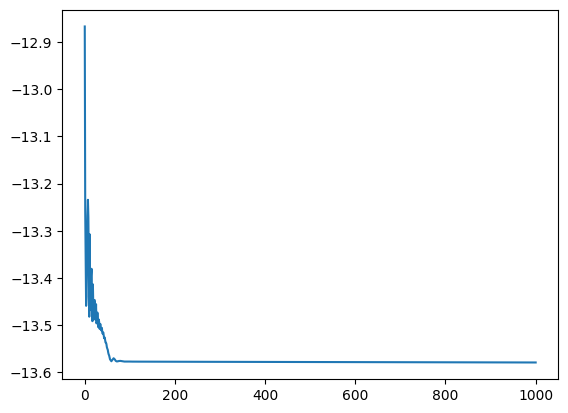

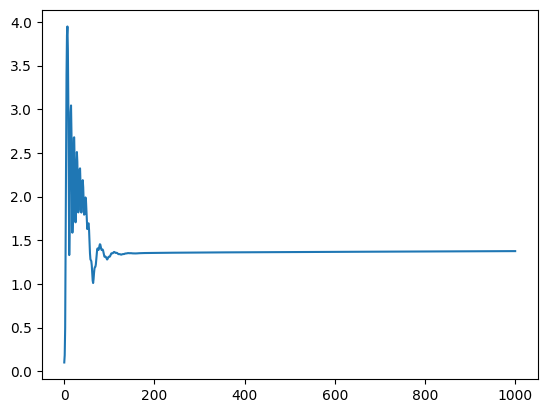

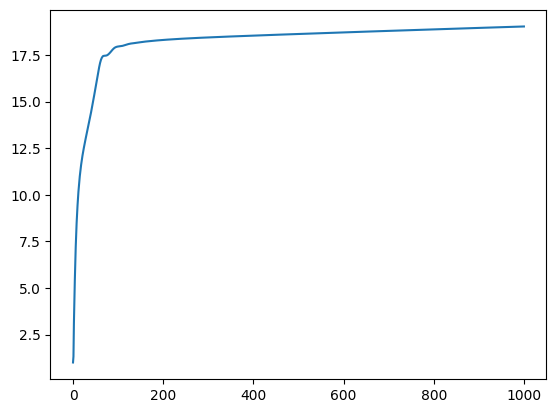

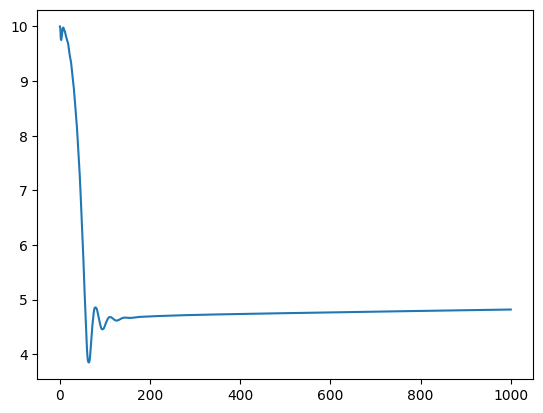

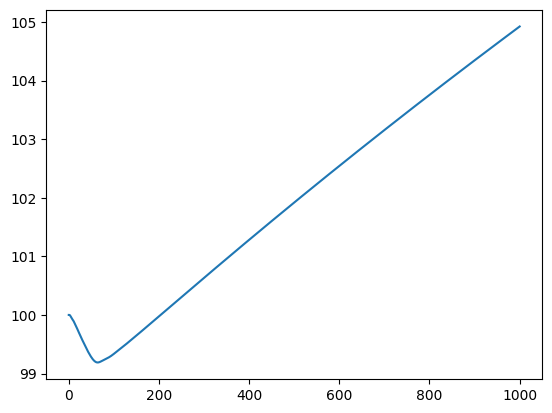

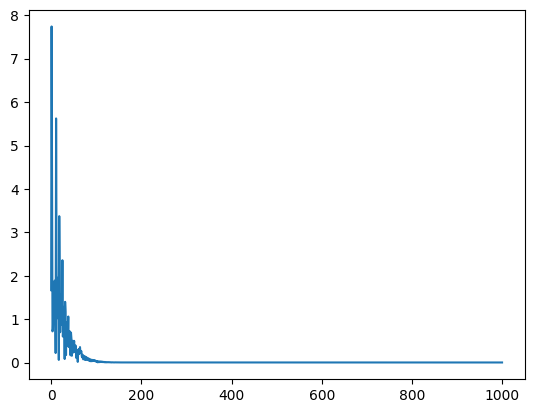

In [15]:
test = MGD(0.1,1,10,100,0.2,1000)
for ele in range(1,7) :
    plt.figure(ele)
    plt.plot(test[0,:],test[ele,:])
print(test[:,-1])